# Experimental data analysis

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.signal import decimate, resample, resample_poly

import os
import datetime
from collections import namedtuple


DATA_DIR = os.path.join("240209_temptest_C6B2")
TEMP_IMG_DIR = os.path.join("img_raw")
IMG_DIR = os.path.join("img_raw")
SAVE_FMT = "pdf"
SAVEFIG_PARAMS = {"dpi": 1000, "bbox_inches": "tight"}

plt.style.use("tableau-colorblind10")
# plt.rc("text", usetex=True)
# plt.rc("font", family="serif")

## Data reading

In [6]:
DATA_CHAMBER_FILENAME = os.path.join(DATA_DIR, "chamber.csv")
DATA_SENSOR_FILENAME = os.path.join(DATA_DIR, "sensor_temp.csv")
DATA_CAPACITY_FILENAME = os.path.join(DATA_DIR, "TestData.csv")
DATA_PROCEDURE_FILENAME = os.path.join(DATA_DIR, "TestProcedure.csv")

chamber_df = pd.read_csv(DATA_CHAMBER_FILENAME).drop(["Unnamed: 8"], axis=1, inplace=False)
sensor_df = pd.read_csv(DATA_SENSOR_FILENAME)
cap_df = pd.read_csv(
    DATA_CAPACITY_FILENAME,
    header=0,
    names=["Current", "Voltage", "Capacity", "Cumulative_capacity", "Seconds", "Test_State", "SOC"],
)
# proc_df = pd.read_csv(DATA_PROCEDURE_FILENAME)

display(chamber_df)
display(sensor_df)
# display(eis_df)
display(cap_df)
# display(proc_df)

,DateTime,CSZ System,TEMPERATURE PV,TEMPERATURE SP,TEMPERATURE %Out,PRODUCT PV,PRODUCT SP,PRODUCT %Out
0,2/8/2024 14:54:59,NaN,22.8,23.0,-3.43,23.3,23.0,0.0
1,2/8/2024 14:55:05,NaN,22.8,23.0,4.43,23.4,23.0,0.0
2,2/8/2024 14:55:11,NaN,22.8,23.0,5.83,23.4,23.0,0.0
3,2/8/2024 14:55:17,NaN,22.8,23.0,4.34,23.4,23.0,0.0
4,2/8/2024 14:55:23,NaN,22.8,23.0,1.71,23.5,23.0,0.0
...,...,...,...,...,...,...,...,...
33463,2/12/2024 13:48:54,NaN,39.7,40.0,-4.09,39.7,40.0,0.0
33464,2/12/2024 13:49:00,NaN,39.7,40.0,11.30,39.7,40.0,0.0
33465,2/12/2024 13:49:06,NaN,39.8,40.0,-11.66,39.8,40.0,0.0
33466,2/12/2024 13:49:12,NaN,39.9,23.0,-100.00,39.8,23.0,0.0


,timestamp_utc,unix_time_utc,cell,res_s1,temp_s1,res_s2,temp_s2,res_a1,temp_a1,res_a2,temp_a2
0,2024-02-08 17:56:29.376721+00:00,1707414989,10061.6,23.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-08 17:56:29.379719+00:00,1707414989,0.0,106666.67,24.00,104191.62,24.0,107085.03,23.0,105835.02,24.0
2,2024-02-08 17:56:29.381743+00:00,1707414989,NaN,24.00,105835.02,24.00,NaN,NaN,NaN,NaN,NaN
3,2024-02-08 17:56:29.383718+00:00,1707414989,0.0,104191.62,24.00,104191.62,24.0,101775.15,25.0,110061.60,23.0
4,2024-02-08 17:56:29.385718+00:00,1707414989,0.0,106666.67,24.00,104191.62,24.0,107085.03,23.0,105835.02,24.0
...,...,...,...,...,...,...,...,...,...,...,...
333300,2024-02-12 18:41:12.829708+00:00,1707763272,0.0,105421.69,24.00,103784.87,24.0,100195.70,25.0,107505.07,23.0
333301,2024-02-12 18:41:13.874298+00:00,1707763273,0.0,101775.15,25.00,112240.67,22.0,101775.15,25.0,109202.46,23.0
333302,2024-02-12 18:41:14.917619+00:00,1707763274,0.0,106666.67,24.00,104600.00,24.0,102976.19,24.0,102574.26,24.0
333303,2024-02-12 18:41:15.966464+00:00,1707763275,0.0,105835.02,24.00,110927.84,23.0,105835.02,24.0,106666.67,24.0


,Current,Voltage,Capacity,Cumulative_capacity,Seconds,Test_State,SOC
0,-0.000100,4.15683,0.000000,0.000000,02/08/2024 14:56:39.011613500,2,0.000000
1,-0.000100,4.15680,-0.000030,-0.000030,02/08/2024 14:56:40.095181620,2,-0.000001
2,-0.000100,4.15680,-0.000030,-0.000060,02/08/2024 14:56:41.178775180,2,-0.000003
3,-2.247890,3.71654,0.000000,0.000000,02/08/2024 14:56:55.433992780,1,100.000000
4,-2.247900,3.70629,-0.676585,-0.676585,02/08/2024 14:56:56.517541340,1,99.966700
...,...,...,...,...,...,...,...
163463,0.110377,4.20000,0.033220,2114.600000,02/12/2024 07:02:20.973081140,3,104.014000
163464,0.110321,4.20000,0.033203,2114.630000,02/12/2024 07:02:22.056571680,3,104.015000
163465,0.110251,4.20000,0.033183,2114.660000,02/12/2024 07:02:23.140079340,3,104.017000
163466,0.110183,4.20000,0.033162,2114.700000,02/12/2024 07:02:24.223572900,3,104.018000


## Thermal model inputting

In [3]:
# Temperature model parameters
T_REF = 2.980e2
ALPHA = -5.738
BETA = 2.099e2

# Open-circuit voltage curve parameters
OcvParams = namedtuple("OcvParams", "v0 vl alpha beta gamma")
OCV_V0 = 4.14
OCV_VL = 3.977
OCV_ALPHA = 0.15
OCV_BETA = 17
OCV_GAMMA = 10.5
OCV_PARAMS = OcvParams(OCV_V0, OCV_VL, OCV_ALPHA, OCV_BETA, OCV_GAMMA)

# Entropic-heat coefficient curve parameters
EhcParams = namedtuple("EhcParams", "amplitude kappa mu sigma l")
EHC_AMPLITUDE = 0.04e-3
EHC_KAPPA = 3
EHC_MU = 0.4
EHC_SIGMA = 0.05
EHC_LAMBDA = 7
EHC_PARAMS = EhcParams(EHC_AMPLITUDE, EHC_KAPPA, EHC_MU, EHC_SIGMA, EHC_LAMBDA)

# Simulation parameters
EPSILON = 1e-9
ZERO_CELSIUS_IN_KELVIN = 273

def calculate_soc_coeff(temperature, t_ref=T_REF, a=ALPHA, b=BETA):
    return np.exp(a / (temperature - b) - a / (t_ref - b))


def calculate_soc_with_temperature(soc, temperature, t_ref=T_REF, a=ALPHA, b=BETA):
    return 1 + (soc - 1) / calculate_soc_coeff(temperature, t_ref, a, b)


def calculate_ocv(soc, ocv_params=OCV_PARAMS):
    return ocv_params.vl + (ocv_params.v0 - ocv_params.vl) * np.exp(ocv_params.gamma * (soc - 1)) + ocv_params.alpha * ocv_params.vl * (soc - 1) + (1 - ocv_params.alpha) * ocv_params.vl * (np.exp(-ocv_params.beta) - np.exp(-ocv_params.beta * np.sqrt(soc)))


def calculate_ocv_grad(soc, ocv_params=OCV_PARAMS):
    return ocv_params.gamma * (ocv_params.v0 - ocv_params.vl) * np.exp(ocv_params.gamma * (soc - 1)) + ocv_params.alpha * ocv_params.vl + ((1 - ocv_params.alpha) * ocv_params.vl * ocv_params.beta * np.exp(-ocv_params.beta * np.sqrt(soc))) / (2 * np.sqrt(soc))


def calculate_entropy_change(temperature, soc, a=ALPHA, b=BETA, ocv_params=OCV_PARAMS):
    return (a / ((temperature - b)**2)) * soc * calculate_ocv_grad(soc, ocv_params)


def calculate_entropy_change_kappa(temperature, soc, t_ref=T_REF, a=ALPHA, b=BETA, ocv_params=OCV_PARAMS):
    return (a / ((temperature - b)**2 * calculate_soc_coeff(temperature, t_ref, a, b))) * soc * calculate_ocv_grad(soc, ocv_params)


# Functions for temperature
def celsius_to_kelvin(deg):
    return ZERO_CELSIUS_IN_KELVIN + deg


def kelvin_to_celsius(deg):
    return deg - ZERO_CELSIUS_IN_KELVIN


def entropy_change(soc, ehc_params=EHC_PARAMS):
    return ehc_params.amplitude * (np.exp(-(soc - ehc_params.mu)**2 / (2 * ehc_params.sigma)) / np.sqrt(2 * np.pi * ehc_params.sigma ** 2) - ehc_params.l * np.exp(-ehc_params.kappa * soc)) + 0.05e-3


def calculate_ocv_temperature(soc, temperature, ocv_params=OCV_PARAMS, ehc_params=EHC_PARAMS, t_ref=T_REF):
    return calculate_ocv(soc, ocv_params) + (temperature - t_ref) * entropy_change(soc, ehc_params)


def generated_heat_from_current(current, temperature, soc, internal_resistance):
    return current ** 2 * internal_resistance - current * temperature * entropy_change(soc)


## Plotting the simulation data

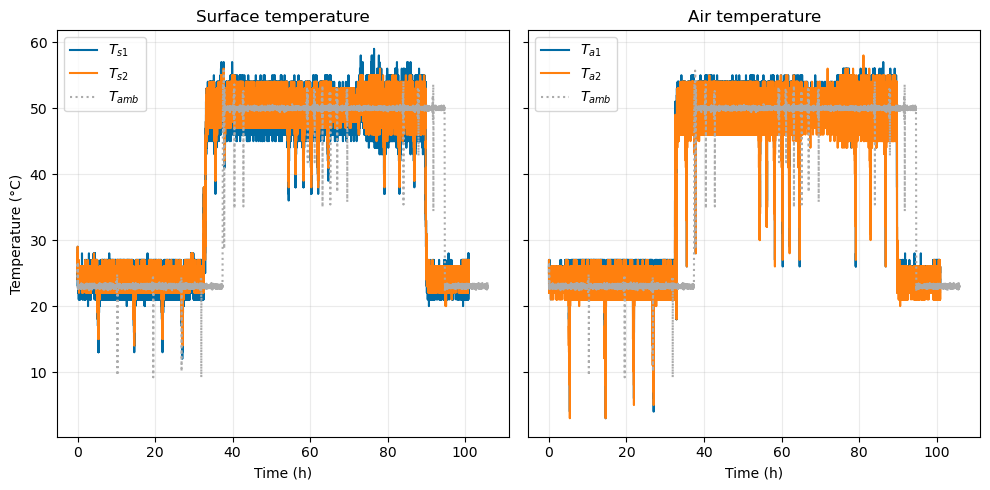

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

seconds_from_start = sensor_df["unix_time_utc"] - sensor_df["unix_time_utc"][0]

chamber_seconds = np.array([datetime.datetime.strptime(d, "%m/%d/%Y %H:%M:%S") for d in chamber_df["DateTime"]])
chamber_seconds = chamber_seconds - chamber_seconds[0]
chamber_seconds = np.array([delta.total_seconds() for delta in chamber_seconds])

ax1.plot(seconds_from_start / 3600, sensor_df["temp_s1"], alpha=1, label="$T_{{s1}}$")
ax1.plot(seconds_from_start / 3600, sensor_df["temp_s2"], alpha=1, label="$T_{{s2}}$")
ax1.plot(chamber_seconds / 3600, chamber_df["TEMPERATURE PV"], linestyle=":", label="$T_{{amb}}$")
ax2.plot(seconds_from_start / 3600, sensor_df["temp_a1"], alpha=1, label="$T_{{a1}}$")
ax2.plot(seconds_from_start / 3600, sensor_df["temp_a2"], alpha=1, label="$T_{{a2}}$")
ax2.plot(chamber_seconds / 3600, chamber_df["TEMPERATURE PV"], linestyle=":", label="$T_{{amb}}$")

ax1.legend()
ax2.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)

ax1.set_xlabel("Time (h)")
ax2.set_xlabel("Time (h)")
ax1.set_ylabel("Temperature (°C)")

ax1.set_title("Surface temperature")
ax2.set_title("Air temperature")

fig.tight_layout()
plt.show()

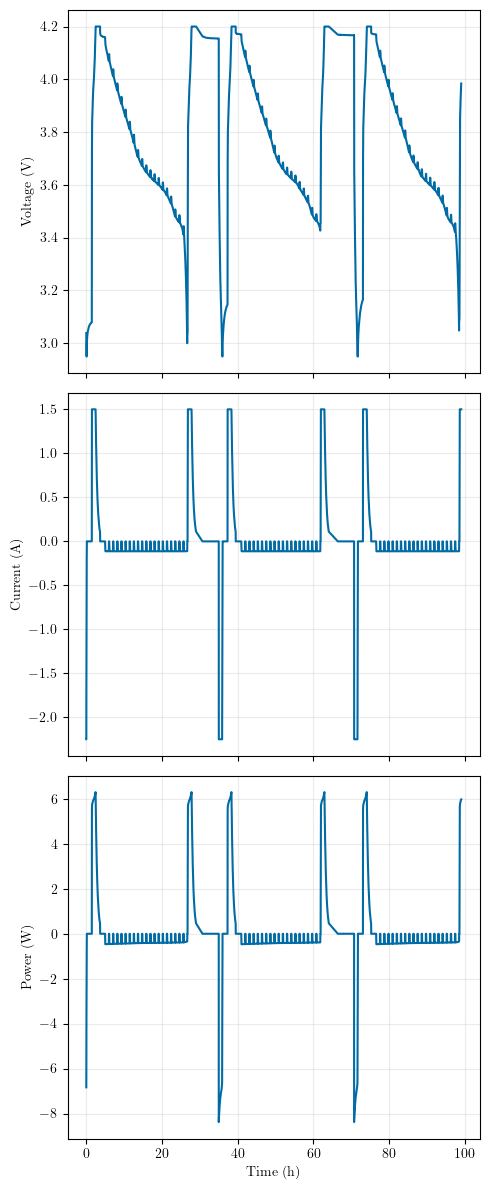

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 12), sharex=True)

seconds_from_start = np.array([datetime.datetime.strptime(d[:-3], "%m/%d/%Y %H:%M:%S.%f") for d in cap_df["Seconds"]])
seconds_from_start = seconds_from_start - seconds_from_start[0]
seconds_from_start = np.array([delta.total_seconds() for delta in seconds_from_start])

ax1.plot(seconds_from_start / 3600, cap_df["Voltage"], alpha=1)
ax2.plot(seconds_from_start / 3600, cap_df["Current"], alpha=1)
ax3.plot(seconds_from_start / 3600, cap_df["Voltage"] * cap_df["Current"], alpha=1)

ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)

ax3.set_xlabel("Time (h)")
ax1.set_ylabel("Voltage (V)")
ax2.set_ylabel("Current (A)")
ax3.set_ylabel("Power (W)")

fig.tight_layout()
plt.show()

In [169]:
np.where(abs(cap_df["Current"] - 0) <= 1e-3)

(array([   415,    416,    417, ..., 300879, 300880, 300881], dtype=int64),)

In [171]:
cap_df["Voltage"][np.where(abs(cap_df["Current"] - 0) <= 1e-3)[0]]

415       2.97781
416       2.97839
417       2.97893
418       2.97944
419       2.97992
           ...   
300877    3.09157
300878    3.09161
300879    3.09165
300880    3.09167
300881    3.09188
Name: Voltage, Length: 73320, dtype: float64

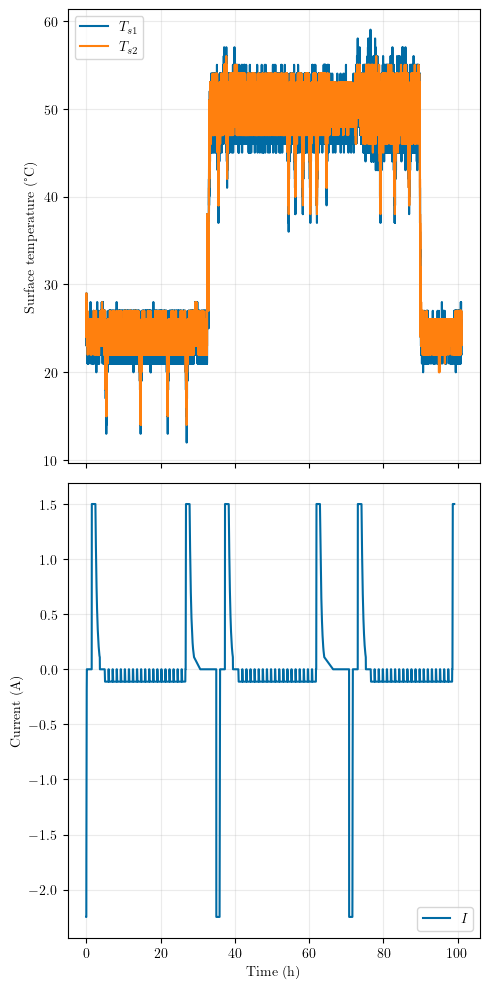

In [163]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

seconds_from_start = sensor_df["unix_time_utc"] - sensor_df["unix_time_utc"][0]
cap_seconds = np.array([datetime.datetime.strptime(d[:-3], "%m/%d/%Y %H:%M:%S.%f") for d in cap_df["Seconds"]])
cap_seconds = cap_seconds - cap_seconds[0]
cap_seconds = np.array([delta.total_seconds() for delta in cap_seconds])


ax1.plot(seconds_from_start / 3600, sensor_df["temp_s1"], alpha=1, label="$T_{{s1}}$")
ax1.plot(seconds_from_start / 3600, sensor_df["temp_s2"], alpha=1, label="$T_{{s2}}$")
ax2.plot(cap_seconds / 3600, cap_df["Current"], alpha=1, label="$I$")

ax1.legend()
ax2.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)

ax2.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
ax2.set_ylabel("Current (A)")

fig.tight_layout()
plt.show()

In [ ]:
106272, 212757

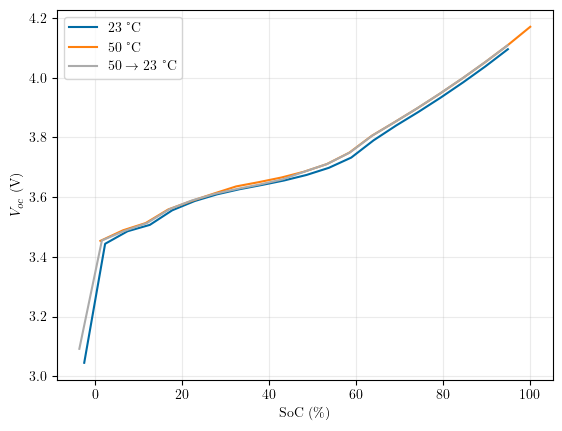

In [246]:
fig, ax = plt.subplots()

# idx = np.where(abs(cap_df["Current"] - 0) <= 1e-3)[0]
# idx = np.where(cap_df["Test_State"] == 6)[0]
idx1 = np.where(cap_df["Test_State"] == 6)[0][np.where(np.where(cap_df["Test_State"] == 6)[0] < 106272)]
idx2 = np.where(cap_df["Test_State"] == 6)[0][np.where((np.where(cap_df["Test_State"] == 6)[0] >= 106272) & (np.where(cap_df["Test_State"] == 6)[0] <= 212757))]
idx3 = np.where(cap_df["Test_State"] == 6)[0][np.where(np.where(cap_df["Test_State"] == 6)[0] > 212757)]

ax.plot(cap_df["SOC"][idx1], cap_df["Voltage"][idx1], label="23 °C")
ax.plot(cap_df["SOC"][idx2], cap_df["Voltage"][idx2], label="50 °C")
ax.plot(cap_df["SOC"][idx3], cap_df["Voltage"][idx3], label="$50\\rightarrow 23$ °C")

ax.legend()

ax.grid(alpha=0.25)

ax.set_xlabel("SoC (\\%)")
ax.set_ylabel("$V_{{oc}}$ (V)")

plt.show()


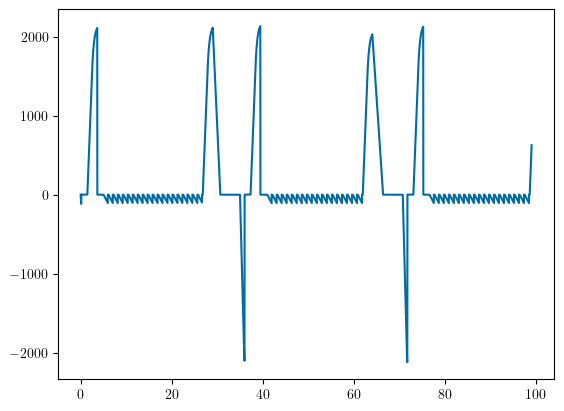

In [159]:
fig, ax = plt.subplots()

seconds_from_start = np.array([datetime.datetime.strptime(d[:-3], "%m/%d/%Y %H:%M:%S.%f") for d in cap_df["Seconds"]])
seconds_from_start = seconds_from_start - seconds_from_start[0]
seconds_from_start = np.array([delta.total_seconds() for delta in seconds_from_start])

ax.plot(seconds_from_start / 3600, cap_df["Cumulative_capacity"])

plt.show()


## Filtering of temperature data
Considering the following variables
$$
\mathbf{x} \triangleq \left(\begin{matrix}
T_{\mathrm{in}} \\
T_{\mathrm{air}} \\
\end{matrix}\right), \mathbf{y} \triangleq \left(\begin{matrix}
T_{\mathrm{s}} \\
T_{\mathrm{air}} \\
\end{matrix}\right), \mathbf{u} \triangleq \left(\begin{matrix}
T_{\mathrm{amb}} \\
q_{\mathrm{gen}} \\
\end{matrix}\right),
$$
then the underlying thermal model for a single cell can be expressed as the following MIMO LTI system
$$
\dot{\mathbf{x}} = \left(\begin{matrix}
-\frac{1}{C_p R_T} & \frac{1}{C_p R_T} \\
\frac{1}{C_{\mathrm{air}} R_T} & -\frac{R_{\mathrm{air}} + R_T}{C_{\mathrm{air}} R_{\mathrm{air}} R_T} \\
\end{matrix}\right)\mathbf{x} + \left(\begin{matrix}
\frac{1}{C_{\mathrm{air}} R_{\mathrm{air}}} & 0 \\
0 & \frac{1}{C_p} \\
\end{matrix}\right)\mathbf{u} \\
\mathbf{y} = \left(\begin{matrix}
\frac{R_{\mathrm{out}}}{R_T} & -\frac{R_{\mathrm{out}}}{R_T} \\
0 & 1 \\
\end{matrix}\right)\mathbf{x},
$$
where $R_{T} \triangleq R_{\mathrm{in}} + R_{\mathrm{out}}$.

In [135]:
sensor_df

,timestamp_utc,unix_time_utc,cell,res_s1,temp_s1,res_s2,temp_s2,res_a1,temp_a1,res_a2,temp_a2
0,2024-01-19 17:58:57.126194+00:00,1705687137,0,93750.01,26,90148.70,27,94857.14,26,98255.82,25
1,2024-01-19 17:58:58.169661+00:00,1705687138,0,99415.21,25,90148.70,27,95229.02,26,99027.25,25
2,2024-01-19 17:58:59.214335+00:00,1705687139,0,92293.24,27,89795.93,27,100982.32,25,98640.77,25
3,2024-01-19 17:59:00.259535+00:00,1705687140,0,92293.24,27,88397.80,28,95602.30,26,99027.25,25
4,2024-01-19 17:59:01.305118+00:00,1705687141,0,92655.38,27,89795.93,27,99804.69,25,94117.65,26
...,...,...,...,...,...,...,...,...,...,...,...
347665,2024-01-23 22:54:46.895912+00:00,1706050486,0,101377.96,25,99027.25,25,105010.03,24,113569.93,22
347666,2024-01-23 22:54:47.941299+00:00,1706050487,0,103379.72,24,99415.21,25,104600.00,24,105010.03,24
347667,2024-01-23 22:54:48.986086+00:00,1706050488,0,103379.72,24,100195.70,25,105010.03,24,107926.82,23
347668,2024-01-23 22:54:50.030603+00:00,1706050490,0,100982.32,25,101377.96,25,105010.03,24,108775.50,23


### MMSEE

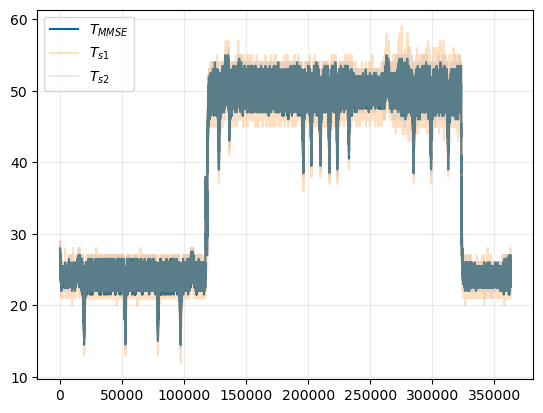

In [22]:
surface_temp = 0.5 * sensor_df["temp_s1"] + 0.5 * sensor_df["temp_s2"]
air_temp = 0.5 * sensor_df["temp_a1"] + 0.5 * sensor_df["temp_a2"]

seconds_from_start = sensor_df["unix_time_utc"] - sensor_df["unix_time_utc"][0]

fig, ax = plt.subplots()
ax.plot(seconds_from_start, 0.5 * sensor_df["temp_s1"] + 0.5 * sensor_df["temp_s2"], label="$T_{{MMSE}}$", alpha=1)
ax.plot(seconds_from_start, sensor_df["temp_s1"], alpha=0.25, label="$T_{{s1}}$")
ax.plot(seconds_from_start, sensor_df["temp_s2"], alpha=0.25, label="$T_{{s2}}$")

ax.legend()
ax.grid(alpha=0.25)

plt.show()

### Synchronization

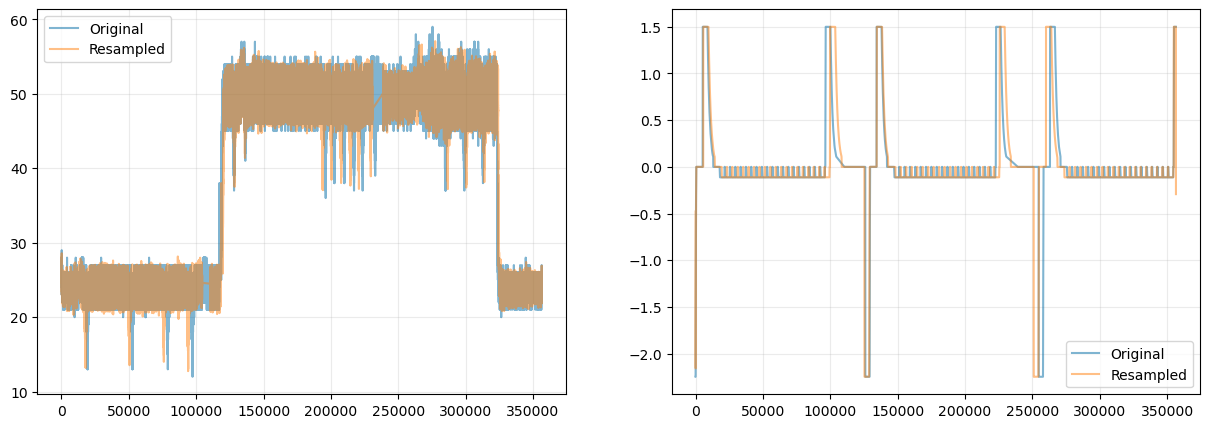

In [142]:
### Sync temperature sensor and capacity test ###

_SYNC_TOTAL = 6514
sensor_seconds = (sensor_df["unix_time_utc"] - sensor_df["unix_time_utc"][0]).to_numpy()[:-_SYNC_TOTAL]

cap_seconds = np.array([datetime.datetime.strptime(d[:-3], "%m/%d/%Y %H:%M:%S.%f") for d in cap_df["Seconds"]])
cap_seconds = cap_seconds - cap_seconds[0]
cap_seconds = np.array([delta.total_seconds() for delta in cap_seconds])

temp_s1 = sensor_df["temp_s1"][:-_SYNC_TOTAL]
temp_s2 = sensor_df["temp_s2"][:-_SYNC_TOTAL]

current = cap_df["Current"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(sensor_seconds, sensor_df["temp_s1"][:-_SYNC_TOTAL], alpha=0.5, label="Original")
ax1.plot(cap_seconds, resample(temp_s1, len(current)), alpha=0.5, label="Resampled")
# ax1.plot(cap_seconds, resample_poly(temp_s1, len(current), len(temp_s1)), alpha=0.5, label="Resampled, poly")
# ax1.plot(cap_seconds, decimate(temp_s1, len(current) / len(temp_s1)), alpha=0.5, label="Decimated")

ax1.legend()
ax1.grid(alpha=0.25)


ax2.plot(cap_seconds, current, alpha=0.5, label="Original")
ax2.plot(sensor_seconds, resample(current, len(sensor_seconds), window=500), alpha=0.5, label="Resampled")
# ax2.plot(sensor_seconds, resample_poly(current, len(sensor_seconds), len(current)), alpha=0.5, label="Resampled, poly")

ax2.legend()
ax2.grid(alpha=0.25)

plt.show()

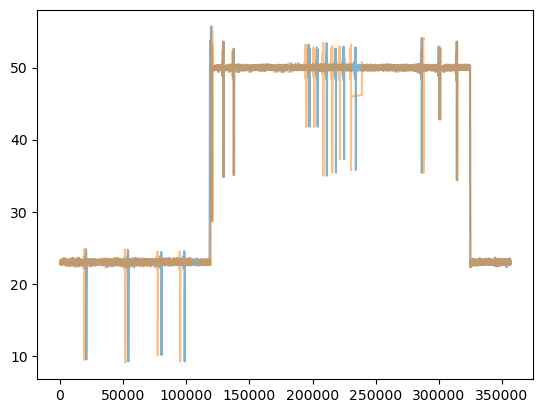

In [235]:
### Sync sensor data and temperature chamber ###

_SYNC_TOTAL = 6514
sensor_seconds = (sensor_df["unix_time_utc"] - sensor_df["unix_time_utc"][0]).to_numpy()[:-_SYNC_TOTAL]

cap_seconds = np.array([datetime.datetime.strptime(d[:-3], "%m/%d/%Y %H:%M:%S.%f") for d in cap_df["Seconds"]])
cap_seconds = cap_seconds - cap_seconds[0]
cap_seconds = np.array([delta.total_seconds() for delta in cap_seconds])

chamber_seconds = np.array([datetime.datetime.strptime(d, "%m/%d/%Y %H:%M:%S") for d in chamber_df["DateTime"]])
chamber_seconds = chamber_seconds - chamber_seconds[0]
chamber_seconds = np.array([delta.total_seconds() for delta in chamber_seconds])

current = cap_df["Current"]

temp_s1 = resample(sensor_df["temp_s1"][:-_SYNC_TOTAL], len(current))
temp_amb = chamber_df["PRODUCT PV"]

fig, ax = plt.subplots()

_LOW = 2700
_HIGH = 1322
ax.plot(chamber_seconds[_LOW:-_HIGH] - chamber_seconds[_LOW], temp_amb[_LOW:-_HIGH], alpha=0.5, label="Original")
ax.plot(cap_seconds, resample(temp_amb[_LOW:-_HIGH], len(cap_seconds)), alpha=0.5, label="Resampled")

plt.show()

### Kalman filter

#### Resampling

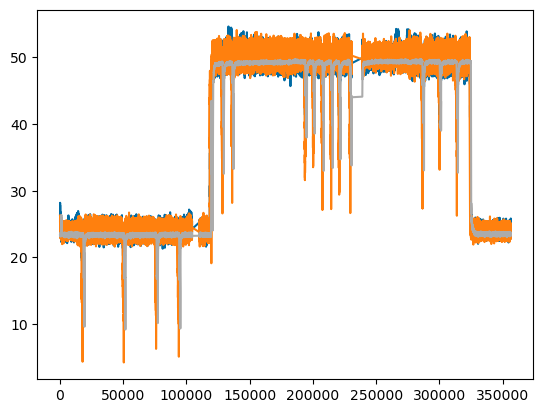

In [245]:
_SYNC_TOTAL = 6514
_LOW = 2700
_HIGH = 1322

time = np.array([datetime.datetime.strptime(d[:-3], "%m/%d/%Y %H:%M:%S.%f") for d in cap_df["Seconds"]])
time = time - time[0]
time = np.array([delta.total_seconds() for delta in time])

temp_s1 = sensor_df["temp_s1"][:-_SYNC_TOTAL]
temp_s2 = sensor_df["temp_s2"][:-_SYNC_TOTAL]
temp_a1 = sensor_df["temp_a1"][:-_SYNC_TOTAL]
temp_a2 = sensor_df["temp_a2"][:-_SYNC_TOTAL]
temp_amb = chamber_df["PRODUCT PV"][_LOW:-_HIGH]

current = cap_df["Current"]

temp_s1 = resample(temp_s1, len(current))
temp_s2 = resample(temp_s2, len(current))
temp_a1 = resample(temp_a1, len(current))
temp_a2 = resample(temp_a2, len(current))

temp_srf = 0.5 * (temp_s1 + temp_s2)
temp_air = 0.5 * (temp_a1 + temp_a2)
temp_amb = resample(temp_amb, len(current))

plt.plot(time, temp_srf)
plt.plot(time, temp_air)
plt.plot(time, temp_amb)
